In [1]:
import matplotlib.pyplot as plt
import numpy as np

def csf_barten_frequency(f,L,X=40):
    '''
    Implements simplified CSF from Peter Barten,"Formula for the contrast sensitivity of the human eye", Electronic Imaging 2004
    '''
    
    num = 5200*np.exp(-0.0016*(f**2)*((1+100/L)**0.08))
    denom1 = 1+144/X**2+0.64*f**2
    denom21 = 63/L**0.83
    denom22 = 1/(1e-4+1-np.exp(-0.02*(f**2)))
    denom2 =denom21+denom22 
    csf_freq = num/(np.sqrt(denom1*denom2))
    return csf_freq

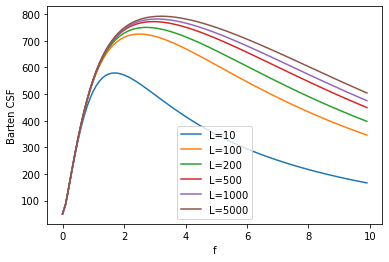

In [2]:
f = np.arange(0,10,0.1)
bart = []
L = [10,100,200,500,1000,5000]
for ls in L:
    bart.append(csf_barten_frequency(f,ls,X=40))
for i in range(len(L)):
    plt.plot(f,bart[i],label="L="+str(L[i]))
plt.legend()
plt.xlabel('f')
plt.ylabel('Barten CSF')
plt.show()

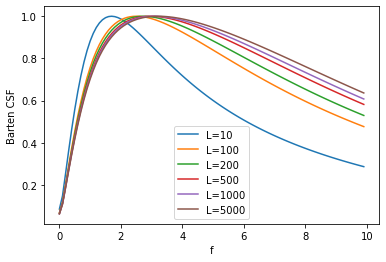

In [3]:
for i in range(len(L)):
    plt.plot(f,bart[i]/np.amax(bart[i]),label="L="+str(L[i]))
plt.xlabel('f')
plt.ylabel('Barten CSF')
plt.legend()
plt.show()

(100,)


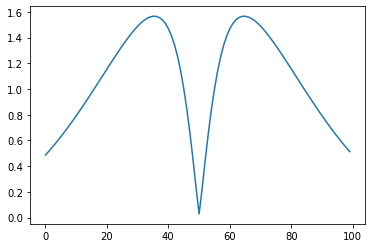

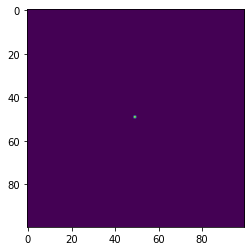

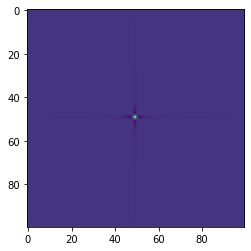

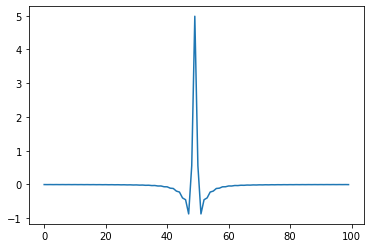

In [4]:

TV_HEIGHT = 32.6
VIEWING_DIST = 1.5*TV_HEIGHT
theta = TV_HEIGHT/2160*180/np.pi*1/VIEWING_DIST
f_max = 1/theta
h_win = 45 
w_win = 45 
X =h_win/2160*1/1.5
f = np.arange(0,10,0.1)
csf_mat = csf_barten_frequency(f,100,40)
print(csf_mat.shape)

block = np.zeros((100,100))
block[49,49]=1

h,w = block.shape
u_min = -(h >> 1)
u_max = (h >> 1) + 1 if h & 1 else (h >> 1)
v_min = -(w >> 1)
v_max = (w >> 1) + 1 if w & 1 else (w >> 1)

u, v = np.meshgrid(np.arange(u_min, u_max), np.arange(v_min, v_max), indexing='ij')
fx, fy = u*f_max/h, v*f_max/w

csf_mat = csf_barten_frequency(np.abs(fx),100,X) * csf_barten_frequency(np.abs(fy),100,X)
plt.figure()
plt.plot(csf_mat[49,:])
plt.show()
block_csf_filtered = np.real(np.fft.ifft2(np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(block)) * csf_mat)))
plt.figure()
plt.imshow(block)
plt.figure()
plt.imshow(block_csf_filtered)
plt.figure()
plt.plot(block_csf_filtered[49,:])

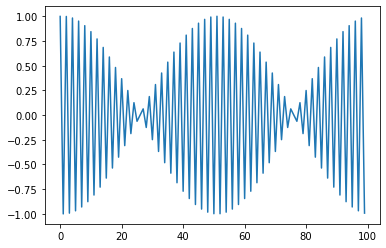

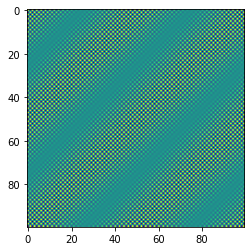

In [5]:

I_fft = np.real(np.fft.fftshift(np.fft.fft2(block)))
#csf_fft = np.real(np.fft.fftshift(np.fft.fft2(

plt.plot(I_fft[49,:])
plt.figure()
plt.imshow(I_fft)
#plt.imshow(csf_fft)
#plt.figure()


(21,)
(21,)
(21,)
(21,)
(21,)
(21,)


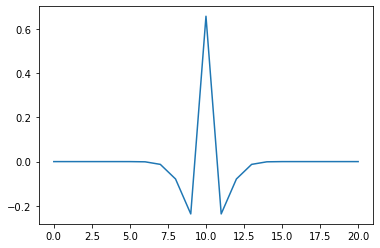

Error in callback <function flush_figures at 0x7f29916cf5e0> (for post_execute):


KeyboardInterrupt: 

In [6]:
from ChipQA.save_stats import gen_gauss_window
import numpy as np

I = np.zeros(21)
I[10]=1

mscn_num = I- np.asarray(gen_gauss_window(len(I)//2, 7.0/6.0))


TV_HEIGHT = 32.6
VIEWING_DIST = 1.5*TV_HEIGHT
theta = TV_HEIGHT/2160*180/np.pi*1/VIEWING_DIST
f_max = 1/theta
h,w = len(mscn_num),len(mscn_num)
u_min = -(h >> 1)
u_max = (h >> 1) + 1 if h & 1 else (h >> 1)
v_min = -(w >> 1)
v_max = (w >> 1) + 1 if w & 1 else (w >> 1)

u, v = np.meshgrid(np.arange(u_min, u_max), np.arange(v_min, v_max), indexing='ij')
fx, fy = u*f_max/h, v*f_max/w
fx= np.arange(u_min, u_max)*f_max/h
plt.figure()
plt.plot(mscn_num)


f, (ax1, ax2) = plt.subplots(1, 2)
mscn_fft = np.abs(np.fft.fftshift(np.fft.fft(mscn_num)))

L = [10,100,200,500,1000,5000]
for ls in L:
    csf = csf_barten_frequency(fx,ls,X=40)
    csf = csf/np.amax(csf)
    ax1.plot(csf,label='csf L='+str(ls))
    print(csf.shape)
    combine = mscn_fft*csf
    ax2.plot(combine,label='csf x mscn num. L='+str(ls))
ax1.plot(mscn_fft,label='mscn num.')
ax1.legend()
ax2.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)



In [7]:
import time
import pandas as pd
from utils.hdr_utils import hdr_yuv_read
from utils.csf_utils import blockwise_csf,windows_csf
from joblib import Parallel,delayed
import numpy as np
import cv2
import queue
import glob
from colour.models import eotf_PQ_BT2100
import os
import time
import scipy.ndimage
import joblib
from scipy.stats import gmean
import sys
import matplotlib.pyplot as plt
import ChipQA.niqe 
import ChipQA.save_stats
from numba import jit,prange
import argparse
from scipy.stats import kurtosis
from skimage.util.shape import view_as_blocks
 

  

def spatial_mscn(i,filenames,framenum,hs,ws,use_csf=True,linear=True):
    filename = filenames[i]
    name = os.path.basename(filename)
    print(name) 
    framenos = framenos_list[i]



    # SIZE of frames
    h,w = hs[i],ws[i]
    print(h,w)
    if(h>w):
        h_temp = h
        h=w
        w = h_temp
        
    # SIZE of windows
    h_win,w_win = 45,45
    max_h,max_w = int((h//h_win)*h_win),int((w//w_win)*w_win)
    #percent by which the image is resized
    scale_percent = 0.5
    # dsize
    dsize = (int(scale_percent*h),int(scale_percent*w))

    # opening file object
    dis_file_object = open(filename)
    prevY_pq,_,_ = hdr_yuv_read(dis_file_object,framenum,h,w)
    count=1
    prevY_pq = prevY_pq.astype(np.float32)
    if(linear==True):
        y_pq_normalized = prevY_pq.astype(np.float32)/1024.0
        prevY_pq = eotf_PQ_BT2100(y_pq_normalized)
    Y = prevY_pq


    Y_mscn,_,_ = ChipQA.save_stats.compute_image_mscn_transform(Y)

    

#    for ls in [100,300,500]:
    Y_csf = blockwise_csf(Y,adaptation='gaussian',h_win=h_win,w_win=w_win)
    Y_csf_mscn,_,_ = ChipQA.save_stats.compute_image_mscn_transform(Y_csf)
    

    return Y, Y_mscn,Y_csf,Y_csf_mscn






In [8]:
input_folder = '/media/josh/hdr/fall2021_hdr_yuv'
csv_file = './fall2021_yuv_rw_info.csv'
csv_df = pd.read_csv(csv_file)
files = [os.path.join(input_folder,f) for f in csv_df["yuv"]]
for i,f in enumerate(files):
    print(i,f)
fps = csv_df["fps"]
framenos_list = csv_df["framenos"]
ws =csv_df["w"]
hs = csv_df["h"]
flag = 0
#    Parallel(n_jobs=5)(delayed(sts_fromfilename)(i,files,framenos_list,args.results_folder,use_csf=False) for i in range(len(files)))
Y,Y_mscn,Y_csf,Y_csf_mscn = spatial_mscn(188,files,10,hs,ws,linear=False)



0 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_Bonfire.yuv
1 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_CargoBoat.yuv
2 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_CenterPanorama.yuv
3 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_Chasing1.yuv
4 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_Chasing3.yuv
5 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_Chasing4.yuv
6 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_CourtYard.yuv
7 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_Daylight1.yuv
8 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_firework.yuv
9 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_Flowers.yuv
10 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_football10.yuv
11 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_football1.yuv
12 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_football2.yuv
13 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_football3.yuv
14 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_football4.yuv
15 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_football5.yuv
16 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_football6.yuv
17 /media

[[-0.2642717  -0.18588156 -0.36919624 ..., -0.09749489 -0.29278538
   0.06628232]
 [-0.7700523  -0.2757485   0.33176365 ...,  0.23070486 -0.12056096
  -0.35255942]
 [-0.7866382  -0.45244965  0.52808243 ...,  0.17647073  0.30819905
  -0.08078617]
 ..., 
 [ 0.6574572   0.43946382 -0.06904466 ...,  0.5486193   0.3616058
   0.3055233 ]
 [ 1.0424266   0.79820037 -0.12382179 ...,  0.76881325  0.8666248
  -0.08035641]
 [ 0.27758318  0.3147059  -0.20237212 ...,  0.84479934  1.1227915
  -0.11635095]]


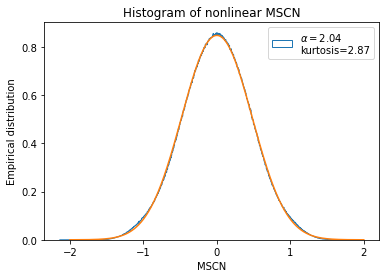

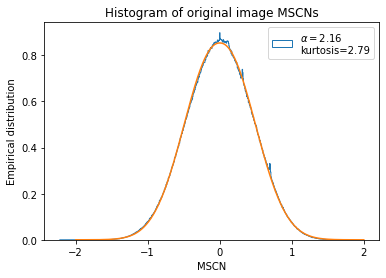

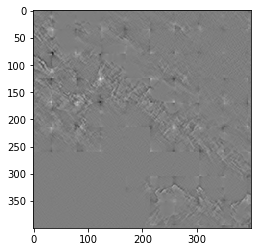

<Figure size 432x288 with 0 Axes>

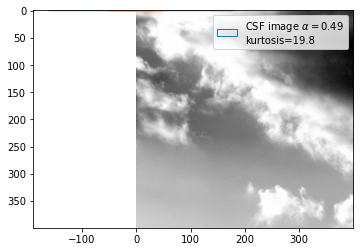

In [18]:

print(Y_csf_mscn)
Yplot = np.concatenate(Y_csf_mscn).flatten()
alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
x = np.arange(-2,2,0.001)
Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)
   

# plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
#plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)


plt.figure()
plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4],density=True)
plt.plot(x,Y_ggd)
plt.ylabel('Empirical distribution')
plt.xlabel('MSCN')
plt.title('Histogram of nonlinear MSCN')
plt.legend()
plt.show()


Yplot = np.concatenate(Y_mscn).flatten()
alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
x = np.arange(-2,2,0.001)
Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)

plt.figure()
plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4],density=True)
plt.plot(x,Y_ggd)
plt.ylabel('Empirical distribution')
plt.xlabel('MSCN')
plt.title('Histogram of original image MSCNs')
plt.legend()
plt.show()
    
plt.figure()
plt.clf()
Y_csf_norm = (Y_csf[100:500,100:500]-np.amin(Y_csf[100:500,100:500]))/(np.amax(Y_csf[100:500,100:500])-np.amin(Y_csf[100:500,100:500]))
plt.imshow(Y_csf_norm,cmap='gray')
plt.figure()
plt.clf()

plt.figure()
plt.clf()
Y_csf_norm = (Y[100:500,100:500]-np.amin(Y[100:500,100:500]))/(np.amax(Y[100:500,100:500])-np.amin(Y[100:500,100:500]))
plt.imshow(Y_csf_norm,cmap='gray')

Yplot = Y_csf.flatten()
alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
x = np.arange(-50,50,0.001)
Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)

plt.hist(Yplot,bins='auto',histtype='step',label=r'CSF image $\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4],density=True)
plt.plot(x,Y_ggd)
plt.legend()
plt.show()